In [104]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torchaudio.transforms as T
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from torchsummary import summary
import src.preprocessor as preprocessor
plt.style.use("ggplot")
torch.manual_seed(42)

## Prepare the dataframe with dataset

In [105]:
df = pd.read_csv("files/wavs1.csv")
df.head()

,path,accents,sentence
0,common_voice_en_37476269.mp3,United States English,This led to both the Red Terror and the White ...
1,common_voice_en_37740889.mp3,England English,Paper wine labels have long been collected
2,common_voice_en_37607972.mp3,United States English,The number of chime sets matches the number of...
3,common_voice_en_37437567.mp3,United States English,The Atbara flows only while there is rain in E...
4,common_voice_en_37288403.mp3,United States English,Katsande and her son were accused of voter int...


In [106]:
# prepenf the path 'files/wavs/' to the file names in the 'path' column and change the file format from .mp3 to .wav

df["path"] = "files/wav/" + df["path"].str.replace(".mp3", ".wav")
df.head()

,path,accents,sentence
0,files/wav/common_voice_en_37476269.wav,United States English,This led to both the Red Terror and the White ...
1,files/wav/common_voice_en_37740889.wav,England English,Paper wine labels have long been collected
2,files/wav/common_voice_en_37607972.wav,United States English,The number of chime sets matches the number of...
3,files/wav/common_voice_en_37437567.wav,United States English,The Atbara flows only while there is rain in E...
4,files/wav/common_voice_en_37288403.wav,United States English,Katsande and her son were accused of voter int...


In [107]:
for filename in df['path']:
    if not os.path.exists(filename):
        print(filename)
        break

In [108]:
# show the counts of all accents
df['accents'].value_counts()

accents
United States English                                 786
United States English,Scandinavian                    332
Canadian English                                      276
German English,Non native speaker                     247
England English                                       112
Malaysian English                                      90
United States English,Filipino                         52
Southern African (South Africa, Zimbabwe, Namibia)     39
Australian English                                     15
Name: count, dtype: int64

accents
United States English                 247
Canadian English                      247
United States English,Scandinavian    247
German English,Non native speaker     247
Name: count, dtype: int64


<Axes: xlabel='accents'>

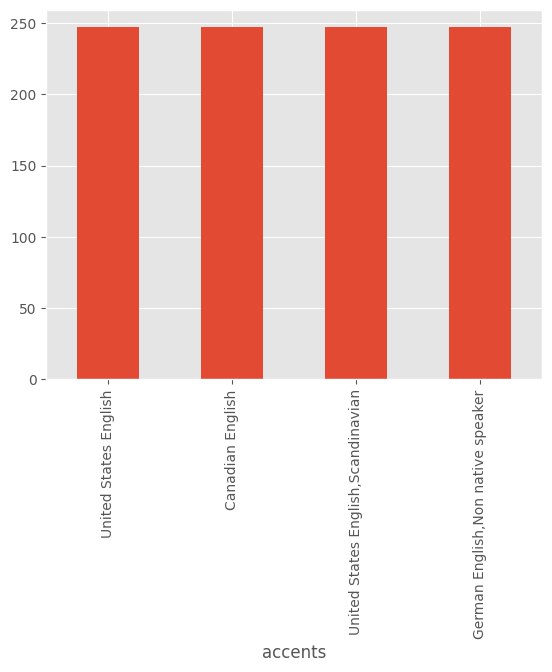

In [109]:
accent_counts = df['accents'].value_counts()

# Identify top 4 accents
top_4_accents = accent_counts.head(4).index.tolist()

# Determine the minimum count among top 4 accents
min_count = min(accent_counts.head(4))

df = df[df['accents'].isin(top_4_accents)].groupby('accents').head(min_count)

df.reset_index(drop=True, inplace=True)

print(df['accents'].value_counts())
df['accents'].value_counts().plot(kind='bar')

In [110]:
# do lable encoding for the accents into a ne column called class_id
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["class_id"] = le.fit_transform(df["accents"])
df.head()


,path,accents,sentence,class_id
0,files/wav/common_voice_en_37476269.wav,United States English,This led to both the Red Terror and the White ...,2
1,files/wav/common_voice_en_37607972.wav,United States English,The number of chime sets matches the number of...,2
2,files/wav/common_voice_en_37437567.wav,United States English,The Atbara flows only while there is rain in E...,2
3,files/wav/common_voice_en_37288403.wav,United States English,Katsande and her son were accused of voter int...,2
4,files/wav/common_voice_en_37306834.wav,United States English,Data was stored in bigendian format,2


In [111]:
# show the counts of all accents

df["accents"].value_counts()


accents
United States English                 247
Canadian English                      247
United States English,Scandinavian    247
German English,Non native speaker     247
Name: count, dtype: int64

## Data preprocessing

In [112]:
import random 

def double_channel(sig):
    audio, sr = sig
    if audio.shape[0] == 2:
        return sig
    # duplicated = torch.cat([audio, audio])
    duplicated = audio
    return duplicated, sr

def downsample(sig, new_sr=22050):
    audio, sr = sig

    if sr == 22050:
        return sig  # No resampling needed if the sample rate is already 22050
    resampled_audio = T.Resample(sr, new_sr)(audio)
    return resampled_audio, new_sr

def append_trunc(sig, milis=3000):
    audio, sr = sig
    audio_len = audio.shape[1]  # Get the length of the audio signal

    max_len = sr // 1000 * milis  # Calculate the maximum allowable length

    if audio_len > max_len:
        # If the audio signal is longer than the maximum allowable length, truncate it
        audio = audio[:, :max_len]
    elif audio_len < max_len:
        # If the audio signal is shorter than the maximum allowable length, append zeros
        diff = max_len - audio_len
        append_start_len = random.randint(0, diff)
        append_stop_len = diff - append_start_len
        # Create zero tensors for appending
        append_start = torch.zeros(append_start_len)
        append_stop = torch.zeros(append_stop_len)
        # Concatenate the zero tensors with the audio signal
        audio = torch.cat((append_start.unsqueeze(0), audio, append_stop.unsqueeze(0)), dim=1)

    return audio, sr

class SpeechDataset(Dataset):
    def __init__(self, data_fr, data_path):
        self.data_fr = data_fr
        self.data_path = str(data_path)

    def __len__(self):
        return len(self.data_fr)

    def __getitem__(self, idx):
        audio_file = self.data_path + self.data_fr.loc[idx, "path"]
        class_id = self.data_fr.loc[idx, "class_id"]
        aud = preprocessor.load_audio(audio_file)
        rechannel = double_channel(aud)
        downsampl = downsample(rechannel)
        timed = append_trunc(downsampl)
        specgram = preprocessor.spectro_mfcc(timed)
        return specgram, class_id

In [113]:
speech_dataset = SpeechDataset(df, "")

# Random split of 80:20 between training and validation
num_items = len(speech_dataset)
num_train = round(num_items * 0.7)
num_val = num_items - num_train
train_ds, val_ds = random_split(speech_dataset, [num_train, num_val])
# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=15, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=15, shuffle=False)

In [114]:
num_train

692

In [115]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [116]:
train_ds[0]

(tensor([[[-57.6547, -57.6547, -57.6547,  ..., -57.6547, -57.6547, -57.6547],
          [-44.3902, -44.3902, -44.3902,  ..., -57.6547, -57.6547, -57.6547],
          [-57.6547, -57.6547, -57.6547,  ...,  11.6138,  10.9434,   8.0298],
          ...,
          [-57.6547, -57.6547, -57.6547,  ..., -57.6547,  -3.9369,  -2.4814],
          [-37.3937, -37.3937, -37.3937,  ..., -57.6547, -57.6547,   1.0357],
          [-38.5942, -38.5942, -38.5942,  ...,   5.8588,  -4.0466, -57.6547]]]),
 3)

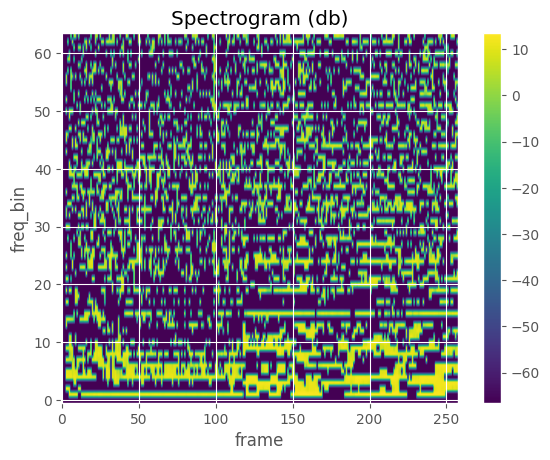

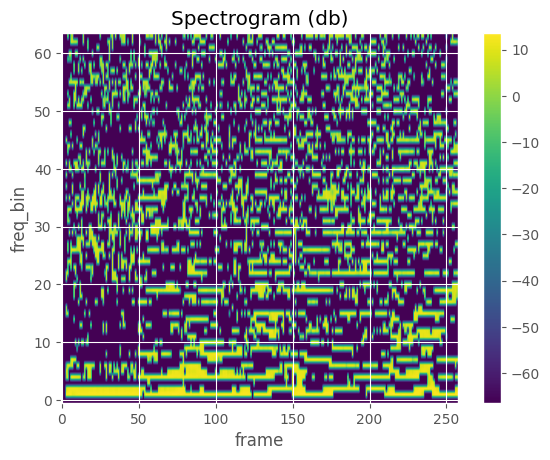

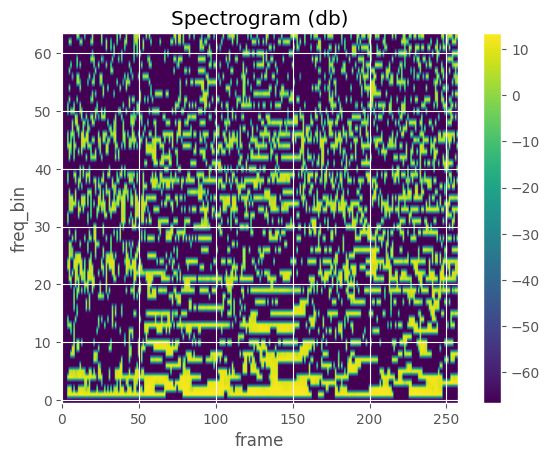

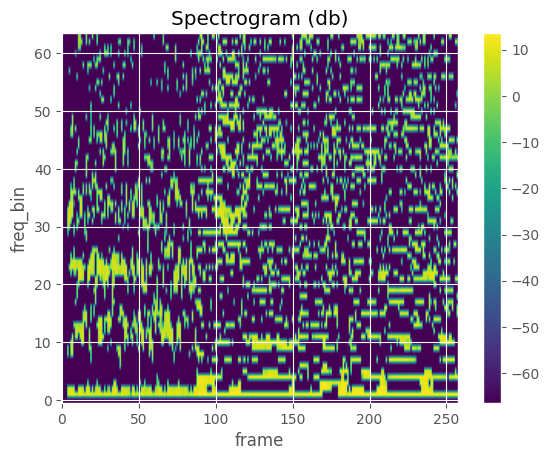

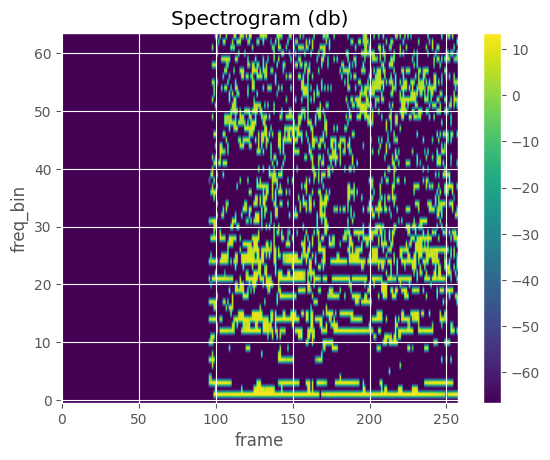

In [117]:
for i in range(5):
    # print(train_ds[i][0].shape)
    plot_spectrogram(train_ds[i][0][0])

## Classifier model

In [118]:
class TDNN(nn.Module):
    def __init__(self):
        super(TDNN, self).__init__()
        # Define the Time-Delay Layers
        self.td_layers = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )
        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.lin = nn.Linear(in_features=32, out_features=11)

    def forward(self, inp_x):
        spectrogram = inp_x

        spectrogram = spectrogram.view(spectrogram.size(0), 1, -1)

        inp_x = self.td_layers(spectrogram)
        inp_x = self.ap(inp_x)  
        inp_x = inp_x.squeeze(-1)
        inp_x = self.dropout(inp_x)
        inp_x = self.lin(inp_x)
        return inp_x

In [119]:
class AccuracyMetric:
    def __init__(self):
        self.correct, self.total = None, None
        self.reset()

    def update(self, y_pred, y_true):
        self.correct += torch.sum(y_pred.argmax(-1) == y_true).item()
        self.total += y_true.size(0)

    def compute(self):
        return self.correct / self.total

    def reset(self):
        self.correct = 0
        self.total = 0

## Training and Inference

In [120]:
# Create the model and put it on the GPU if available

# Example usage:
model = TDNN()
device = torch.device("cpu")
model = model.to(device)
next(model.parameters()).device
summary(model, (2, 1, 258), 11)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [11, 8, 516]              32
              ReLU-2               [11, 8, 516]               0
       BatchNorm1d-3               [11, 8, 516]              16
            Conv1d-4              [11, 16, 516]             400
              ReLU-5              [11, 16, 516]               0
       BatchNorm1d-6              [11, 16, 516]              32
            Conv1d-7              [11, 32, 516]           1,568
              ReLU-8              [11, 32, 516]               0
       BatchNorm1d-9              [11, 32, 516]              64
AdaptiveAvgPool1d-10                [11, 32, 1]               0
          Dropout-11                   [11, 32]               0
           Linear-12                   [11, 11]             363
Total params: 2,475
Trainable params: 2,475
Non-trainable params: 0
-----------------------------------

In [126]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 10

# training loop
train_loss_history = []
train_accuracy_history = []

valid_loss_history = []
valid_accuracy_history = []

accuracy = AccuracyMetric()

for epoch in range(1, epochs + 1):
    print(f"[INFO] Epoch: {epoch}")
    model.train()

    batch_train_loss = []
    batch_valid_loss = []

    for X_batch, y_batch in tqdm(train_dl):
        # perform single training step
        model.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_predicted = model(X_batch)

        loss = criterion(y_predicted, y_batch)
        loss.backward()
        optimizer.step()
        accuracy.update(y_predicted, y_batch)
        batch_train_loss.append(loss.item())

    mean_epoch_loss_train = np.mean(batch_train_loss)
    train_accuracy = accuracy.compute()

    train_loss_history.append(mean_epoch_loss_train)
    train_accuracy_history.append(train_accuracy)
    accuracy.reset()

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_predicted = model(X_batch)

            loss_val = criterion(y_predicted, y_batch)

            accuracy.update(y_predicted, y_batch)
            batch_valid_loss.append(loss_val.item())

    mean_epoch_loss_valid = np.mean(batch_valid_loss)
    valid_accuracy = accuracy.compute()

    valid_loss_history.append(mean_epoch_loss_valid)
    valid_accuracy_history.append(valid_accuracy)
    accuracy.reset()

    print(
        f"Train loss: {mean_epoch_loss_train:0.4f}, Train accuracy: {train_accuracy: 0.4f}"
    )
    print(
        f"Validation loss: {mean_epoch_loss_valid:0.4f}, Validation accuracy: {valid_accuracy: 0.4f}"
    )

[INFO] Epoch: 1


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Train loss: 1.0135, Train accuracy:  0.5997
Validation loss: 1.1061, Validation accuracy:  0.5439
[INFO] Epoch: 2


100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Train loss: 1.0067, Train accuracy:  0.6040
Validation loss: 1.0758, Validation accuracy:  0.5169
[INFO] Epoch: 3


100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Train loss: 1.0094, Train accuracy:  0.5896
Validation loss: 1.1026, Validation accuracy:  0.5372
[INFO] Epoch: 4


100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


Train loss: 0.9752, Train accuracy:  0.6171
Validation loss: 0.9984, Validation accuracy:  0.5980
[INFO] Epoch: 5


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Train loss: 0.9665, Train accuracy:  0.6228
Validation loss: 0.9853, Validation accuracy:  0.6014
[INFO] Epoch: 6


100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Train loss: 0.9628, Train accuracy:  0.6301
Validation loss: 1.6775, Validation accuracy:  0.4561
[INFO] Epoch: 7


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Train loss: 0.9704, Train accuracy:  0.6171
Validation loss: 1.0272, Validation accuracy:  0.5642
[INFO] Epoch: 8


100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Train loss: 0.9563, Train accuracy:  0.6171
Validation loss: 1.1026, Validation accuracy:  0.5135
[INFO] Epoch: 9


100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Train loss: 0.9665, Train accuracy:  0.5737
Validation loss: 1.4297, Validation accuracy:  0.4764
[INFO] Epoch: 10


100%|██████████| 20/20 [00:09<00:00,  2.19it/s]

Train loss: 0.9681, Train accuracy:  0.6142
Validation loss: 1.3311, Validation accuracy:  0.4189


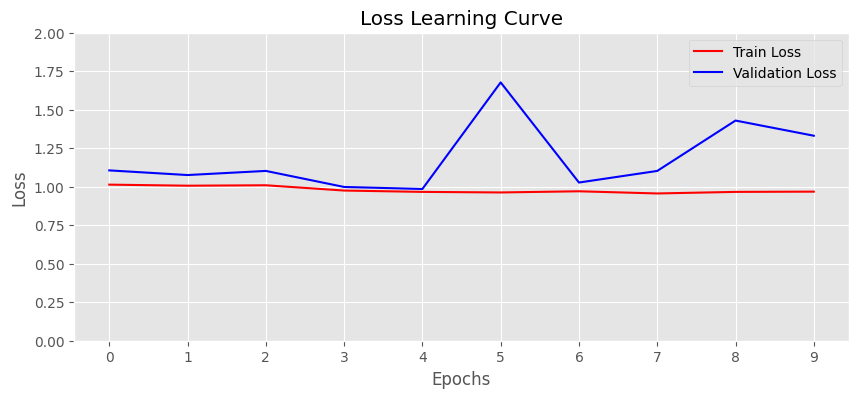

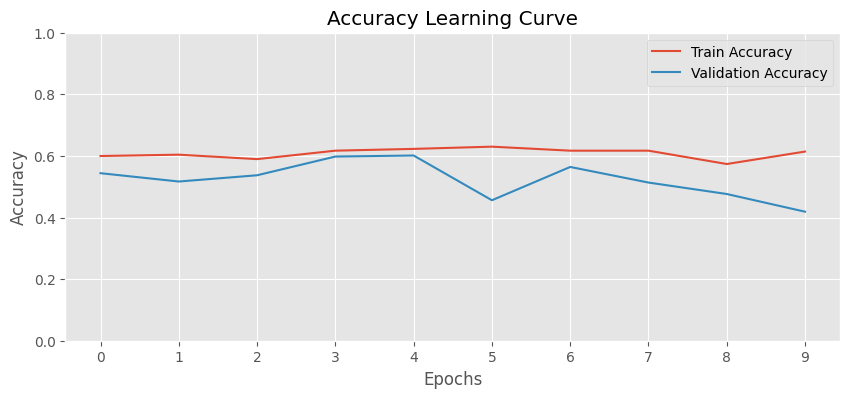

In [127]:
# Loss Learning Curve
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_loss_history, color="r")
plt.plot(valid_loss_history, color="b")
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Learning Curve")
plt.xticks(range(epochs))
plt.ylim(0, 2)  # Set y-axis limits for loss (adjust as needed)
ax.grid(True)

# Accuracy Learning Curve
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_accuracy_history)
plt.plot(valid_accuracy_history)
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Learning Curve")
plt.xticks(range(epochs))
plt.ylim(0, 1)  # Set y-axis limits for accuracy
ax.grid(True)

plt.show()


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


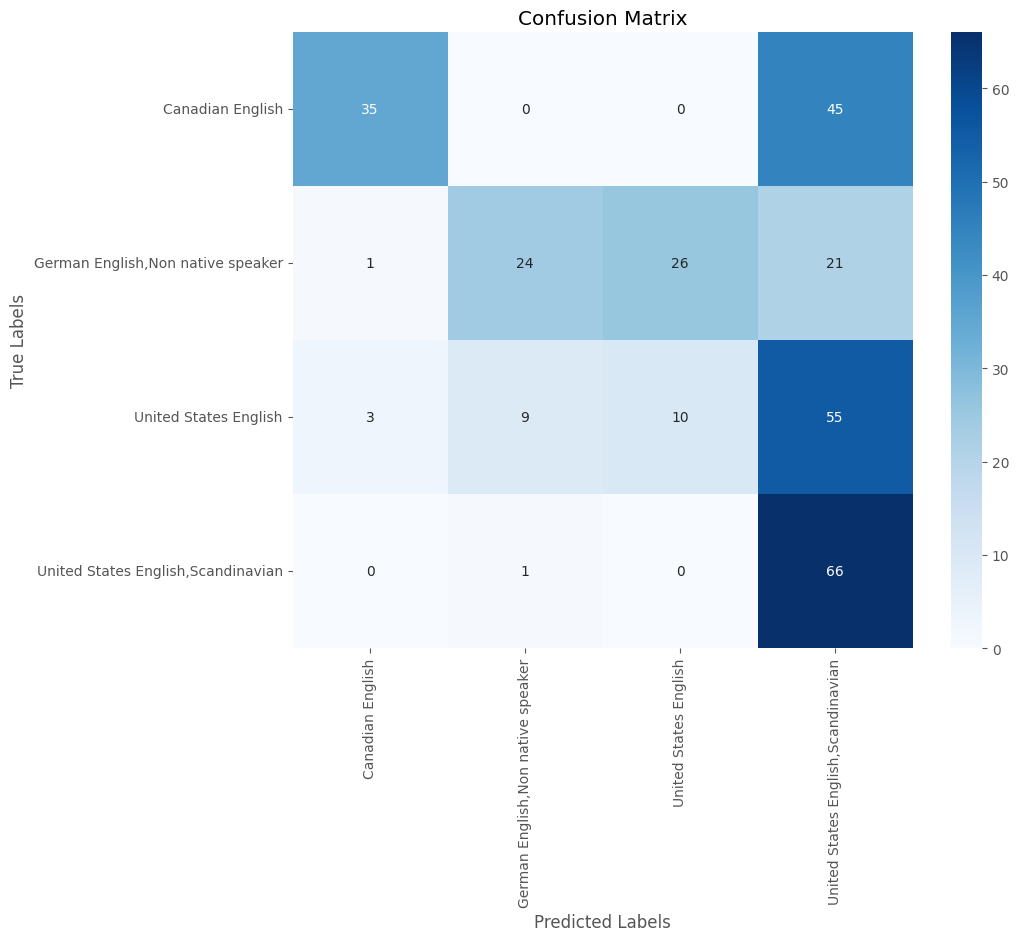

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in tqdm(val_dl):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
